<a href="https://colab.research.google.com/github/kela2023/aah/blob/main/Classification_image_qui_passe2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# les bibliotheques utiles
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import cv2
import requests
import matplotlib.image as mpimg
import sys
import datetime

In [ ]:
import pathlib
data_dir = tf.keras.utils.get_file(
    "test.zip",
    "https://github.com/kela2023/train_images/raw/main/test.zip?raw=true",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/test')
print(data_dir)
print(os.path.abspath(data_dir))




/content/datasets/test
/content/datasets/test


In [ ]:

image_count = len(list(data_dir.glob('*/*')))
print(image_count)

32


In [ ]:
batch_size = 3
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 32 files belonging to 2 classes.
Using 26 files for training.
Found 32 files belonging to 2 classes.
Using 6 files for validation.
['rihanna', 'will']


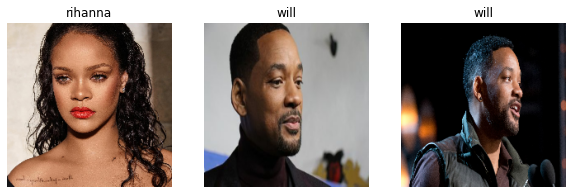

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(3, 200, 200, 3)
(3,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 3s 243ms/step - loss: 1.5956 - accuracy: 0.4231 - val_loss: 0.6440 - val_accuracy: 0.6667
Epoch 2/10
9/9 [==============================] - 2s 224ms/step - loss: 0.4997 - accuracy: 0.8077 - val_loss: 0.8473 - val_accuracy: 0.3333
Epoch 3/10
9/9 [==============================] - 3s 312ms/step - loss: 0.3272 - accuracy: 0.8846 - val_loss: 1.0182 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 2s 221ms/step - loss: 0.1347 - accuracy: 0.9615 - val_loss: 0.3286 - val_accuracy: 0.8333
Epoch 5/10
9/9 [==============================] - 2s 205ms/step - loss: 0.0492 - accuracy: 1.0000 - val_loss: 0.3477 - val_accuracy: 0.8333
Epoch 6/10
9/9 [==============================] - 2s 213ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.4594 - val_accuracy: 0.6667
Epoch 7/10
9/9 [==============================] - 2s 208ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3905 - val_accuracy: 0.6667
Epoch 8/10
9/9 [====

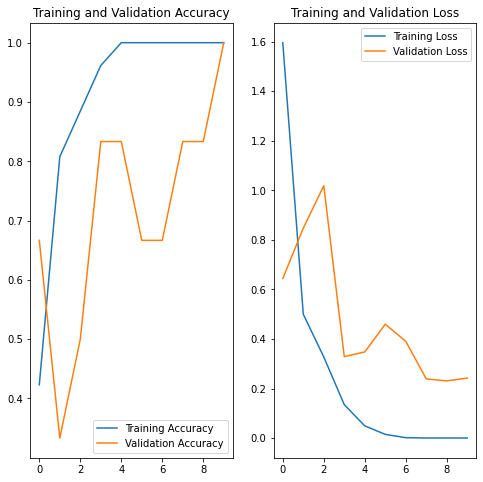

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

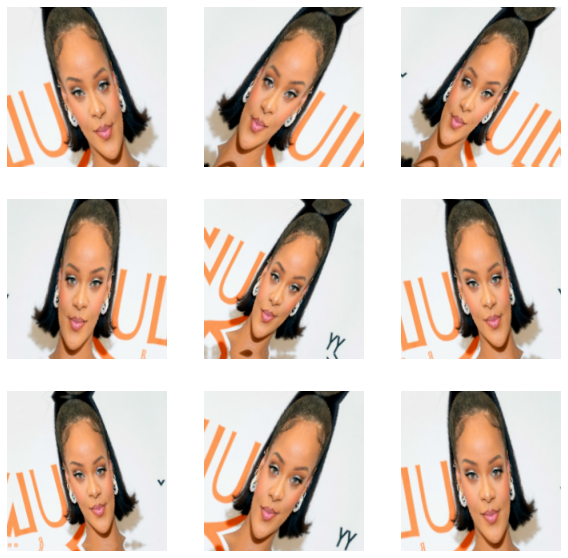

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [113]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/aah')

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......rescaling
.........vars
......sequential
.........layers
............random_flip
...............vars
............random_rotation
...............vars
............random_zoom
...............vars
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimi

In [97]:
model.save('model')

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/15


9/9 [==============================] - 7s 268ms/step - loss: 0.7881 - accuracy: 0.5769 - val_loss: 0.8253 - val_accuracy: 0.5000
Epoch 2/15
9/9 [==============================] - 2s 245ms/step - loss: 0.4362 - accuracy: 0.8077 - val_loss: 0.7506 - val_accuracy: 0.5000
Epoch 3/15
9/9 [==============================] - 2s 234ms/step - loss: 0.2099 - accuracy: 0.9231 - val_loss: 0.9330 - val_accuracy: 0.5000
Epoch 4/15
9/9 [==============================] - 3s 323ms/step - loss: 0.0644 - accuracy: 0.9615 - val_loss: 1.3188 - val_accuracy: 0.6667
Epoch 5/15
9/9 [==============================] - 2s 240ms/step - loss: 0.1092 - accuracy: 0.9231 - val_loss: 2.3925 - val_accuracy: 0.6667
Epoch 6/15
9/9 [==============================] - 2s 236ms/step - loss: 0.0859 - accuracy: 0.9615 - val_loss: 2.0288 - val_accuracy: 0.6667
Epoch 7/15
9/9 [==============================] - 2s 237ms/step - loss: 0.0885 - accuracy: 0.9615 - val_loss: 0.7213 - val_accuracy: 0.8333
Epoch 8/15
9/9 [===============

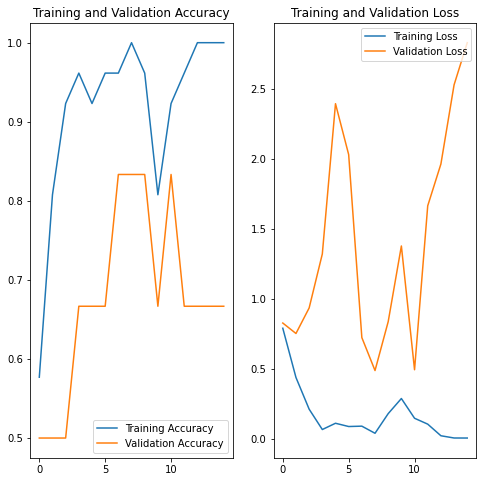

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data = tf.keras.utils.get_file(
    "bb.zip",
    "https://github.com/kela2023/aah/blob/main/bb.zip/?raw=true",
    extract=False
)

import zipfile
with zipfile.ZipFile(data, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/bb')

img_path = data_dir / 'will' / 'download (1).jfif'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 114ms/step
This image most likely belongs to will with a 100.00 percent confidence.
